Installing postgres using Homebrew.  
https://www.dataquest.io/blog/install-postgresql-14-7-for-macos/?_gl=1*1vrbtn6*_gcl_au*NjQ1OTI0MzQxLjE3MTYyNzUyMDY.

# NorthWind Traders Data Analysis

NorthWind Traders is a fictitious international gourmet food distributor. This project aims to provide management with insights in the following areas.  
* Evaluating employee performance to boost productivity.
* Understanding product sales and category performance to optimize inventory and marketing strategies.
* Analyzing sales growth to identify trends, monitor company progress, and make more accurate forecasts.
* And evaluating customer purchase behavior to target high-value customers with promotional incentives.  

The schema is shown as follows. ![image](ER.png)

In [1]:
%load_ext sql
%sql postgresql://postgres@localhost:5432/northwind

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

In [3]:
%%sql --only use this line if running in Jupyter Notebook
SELECT table_name AS name,
       table_type AS type
  FROM information_schema.tables
 WHERE table_schema = 'public' AND table_type IN ('BASE TABLE', 'VIEW');

 * postgresql://postgres@localhost:5432/northwind
14 rows affected.


name,type
territories,BASE TABLE
order_details,BASE TABLE
employee_territories,BASE TABLE
us_states,BASE TABLE
customers,BASE TABLE
orders,BASE TABLE
employees,BASE TABLE
shippers,BASE TABLE
products,BASE TABLE
categories,BASE TABLE


## Sales Performance Based on Employees Performance  
### Total Sales per Employee

In [4]:
query = """
SELECT
    E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
    ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
FROM
    employees E
INNER JOIN orders O ON E.employee_id = O.employee_id
INNER JOIN order_details OD ON O.order_id = OD.order_id
GROUP BY E.employee_id
ORDER BY total_sales DESC
"""
result = %sql $query
employee_sales = pd.DataFrame(result)
employee_sales

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


,employee_id,name,title,total_sales
0,4,Margaret Peacock,Sales Representative,232891
1,3,Janet Leverling,Sales Representative,202813
2,1,Nancy Davolio,Sales Representative,192108
3,2,Andrew Fuller,"Vice President, Sales",166538
4,8,Laura Callahan,Inside Sales Coordinator,126862
5,7,Robert King,Sales Representative,124568
6,9,Anne Dodsworth,Sales Representative,77308
7,6,Michael Suyama,Sales Representative,73913
8,5,Steven Buchanan,Sales Manager,68792


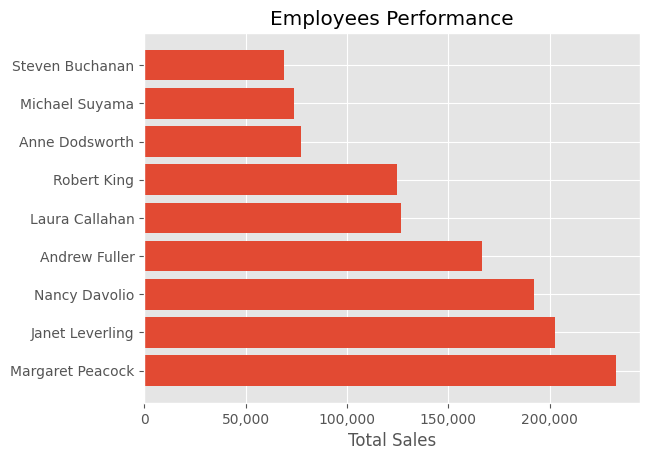

In [5]:
%matplotlib inline
plt.barh(employee_sales["name"], employee_sales["total_sales"])
plt.xlabel("Total Sales")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Employees Performance")
plt.show()

In [6]:
%%sql -- Adding Ranking
SELECT *,
    RANK() OVER(ORDER BY total_sales DESC 
                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS rank
FROM (
    SELECT
        E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
        ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
    FROM
        employees E
    INNER JOIN orders O ON E.employee_id = O.employee_id
    INNER JOIN order_details OD ON O.order_id = OD.order_id
    GROUP BY E.employee_id
    ORDER BY total_sales DESC
) AS sub

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


employee_id,name,title,total_sales,rank
4,Margaret Peacock,Sales Representative,232891,1
3,Janet Leverling,Sales Representative,202813,2
1,Nancy Davolio,Sales Representative,192108,3
2,Andrew Fuller,"Vice President, Sales",166538,4
8,Laura Callahan,Inside Sales Coordinator,126862,5
7,Robert King,Sales Representative,124568,6
9,Anne Dodsworth,Sales Representative,77308,7
6,Michael Suyama,Sales Representative,73913,8
5,Steven Buchanan,Sales Manager,68792,9


Sales Representative, Margaret Peacock, has achieved the greatest total sales in the company. Apart from all time record, I suggest looking at the performance in a shorter time frame such as total sales within the past year.

In [52]:
%%sql -- Adding Ranking
SELECT *,
    RANK() OVER(ORDER BY total_sales DESC 
                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS rank
FROM (
    SELECT
        E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
        ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
    FROM
        employees E
    INNER JOIN orders O ON E.employee_id = O.employee_id
    INNER JOIN order_details OD ON O.order_id = OD.order_id
    WHERE O.order_date >= (SELECT order_date FROM orders ORDER BY 1 DESC LIMIT 1) - INTERVAL '1 year'
    GROUP BY E.employee_id
    ORDER BY total_sales DESC
) AS sub

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


employee_id,name,title,total_sales,rank
3,Janet Leverling,Sales Representative,145543,1
1,Nancy Davolio,Sales Representative,137690,2
4,Margaret Peacock,Sales Representative,127230,3
2,Andrew Fuller,"Vice President, Sales",124173,4
8,Laura Callahan,Inside Sales Coordinator,85137,5
7,Robert King,Sales Representative,81461,6
9,Anne Dodsworth,Sales Representative,64377,7
5,Steven Buchanan,Sales Manager,47888,8
6,Michael Suyama,Sales Representative,43778,9


If only considering the past year, Janet Leverling has the best performance in terms of total sales.

## Company's Overall Sales Performance
### Visualization on Percentage Change by Month

In [59]:
%%sql -- total sales for each month

WITH truncated AS (
    SELECT order_id, DATE_TRUNC('month', order_date) AS date
    FROM orders
)

SELECT
    EXTRACT(YEAR FROM T.date) || '-' || EXTRACT(MONTH FROM T.date) AS month,
    ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS monthly_sales,
    ROUND(SUM(SUM(OD.unit_price * OD.quantity * (1-OD.discount))) 
          OVER(ORDER BY T.date)::numeric, 0) AS RunningTotal
FROM truncated T
INNER JOIN order_details OD ON T.order_id = OD.order_id
GROUP BY T.date
ORDER BY T.date

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


month,monthly_sales,runningtotal
1996-7,27862,27862
1996-8,25485,53347
1996-9,26381,79729
1996-10,37516,117244
1996-11,45600,162844
1996-12,45240,208084
1997-1,61258,269342
1997-2,38484,307826
1997-3,38547,346373
1997-4,53033,399406


In [62]:
query = '''
WITH truncated AS (
    SELECT order_id, DATE_TRUNC('month', order_date) AS date
    FROM orders
)

SELECT
    EXTRACT(YEAR FROM T.date) || '-' || EXTRACT(MONTH FROM T.date) AS month,
    ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS monthly_sales,
    ROUND(SUM(SUM(OD.unit_price * OD.quantity * (1-OD.discount))) 
          OVER(ORDER BY T.date)::numeric, 0) AS RunningTotal
FROM truncated T
INNER JOIN order_details OD ON T.order_id = OD.order_id
GROUP BY T.date
ORDER BY T.date
'''
result = %sql $query
monthly_performance = pd.DataFrame(result)

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


/var/folders/_6/8qgcbw5x5cqgmt_5s5b28mpw0000gn/T/ipykernel_1068/1697456814.py:19: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles=[p1[0],p2[0]], loc='upper center')


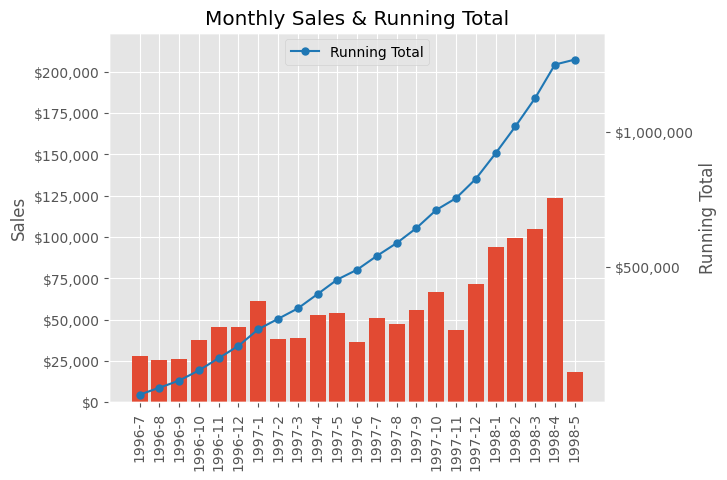

In [142]:
fig, ax = plt.subplots()
twin1 = ax.twinx()

ax.set_title("Monthly Sales & Running Total")

p1 = ax.bar('month', 'monthly_sales', data=monthly_performance, label='Monthly Sales')
ax.set(ylim=(0,monthly_performance['monthly_sales'].max()+100000), ylabel='Sales')
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xticks(monthly_performance['month'], monthly_performance['month'], rotation='vertical')

p2 = twin1.plot('month', 'runningtotal', marker='o', color='tab:blue', markersize=5, data=monthly_performance, label='Running Total')
twin1.set(ylim=(0,monthly_performance['runningtotal'].max()+100000), ylabel='Running Total')
twin1.ticklabel_format(style='plain', axis='y')
twin1.set_yticks([500000,1000000], [500000,1000000])
twin1.yaxis.set_major_formatter('${x:,.0f}')
twin1.grid(False)

ax.legend(handles=[p1[0],p2[0]], loc='upper center')
plt.show()

From 1996-07 to 1997-10, NorthWind's total sales was increasing gradually in a nearly uniform rate. Since 1997-12, performance in terms of sales had been improved as shown in the steeper line and higher bars. However, the performance in the last month in the record dropped significantly.

### Month-Over-Month Growth Rate

In [173]:
query = '''
WITH 
truncated AS (
    SELECT order_id, DATE_TRUNC('month', order_date) AS date
    FROM orders),

monthly AS (
    SELECT 
        T.date,
        EXTRACT(YEAR FROM T.date) || '-' || EXTRACT(MONTH FROM T.date) AS month,
        ROUND(SUM(SUM(OD.unit_price * OD.quantity * (1-OD.discount))) 
              OVER(PARTITION BY T.date)::numeric, 0) AS monthly_sales
    FROM order_details OD
    INNER JOIN truncated T ON OD.order_id = T.order_id
    GROUP BY T.date)

SELECT month, monthly_sales,
    ROUND( (monthly_sales-(LAG(monthly_sales, 1) OVER()))*100/
          (LAG(monthly_sales, 1) OVER())::numeric, 0 ) AS growth_rate
FROM monthly
'''
result = %sql $query
monthly_growth = pd.DataFrame(result)

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


/var/folders/_6/8qgcbw5x5cqgmt_5s5b28mpw0000gn/T/ipykernel_1068/2653754382.py:19: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles=[p1[0],p2[0]], loc='upper center')


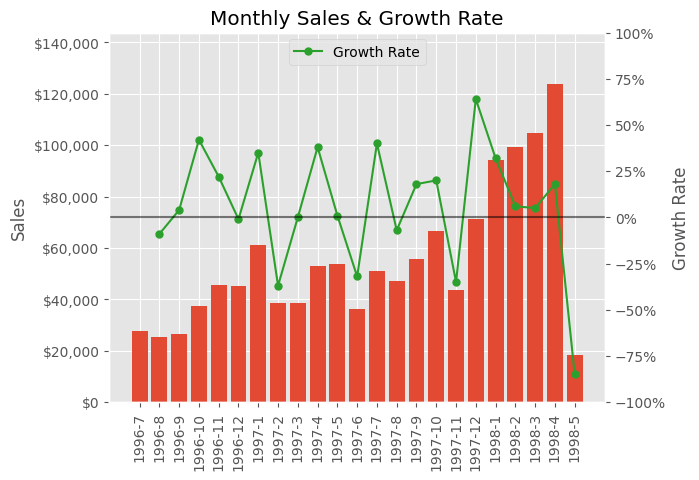

In [182]:
fig, ax = plt.subplots()
twin1 = ax.twinx()

ax.set_title("Monthly Sales & Growth Rate")

p1 = ax.bar('month', 'monthly_sales', data=monthly_growth, label='Monthly Sales')
ax.set(ylim=(0,monthly_growth['monthly_sales'].max()+20000), ylabel='Sales')
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xticks(monthly_growth['month'], monthly_growth['month'], rotation='vertical')

p2 = twin1.plot('month', 'growth_rate', marker='o', color='tab:green', markersize=5, data=monthly_growth, label='Growth Rate')
twin1.set(ylim=(-100,100), ylabel='Growth Rate')
twin1.ticklabel_format(style='plain', axis='y')
twin1.yaxis.set_major_formatter('{x:.0f}%')
twin1.grid(False)
twin1.axhline(0, color='black', alpha=.5)

ax.legend(handles=[p1[0],p2[0]], loc='upper center')
plt.show()